# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요한 라이브러리를 설치합니다.
!pip install timm transformers

In [3]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-q7siclja
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-q7siclja
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Created wheel for RealESRGAN: filename=RealESRGAN-1.0-py3-none-any.whl size=9103 sha256=b569dfdba84f474c2f556ea2438df8bf72ccb953aee55a706080124afa531715
  Stored in directory: /tmp/pip-ephem-wheel-cache-f61aa6jb/wheels/dd/a3/7d/774508ed192455403be294c8a6c4ad1c83dde8fcdd8903e64a
Successfully built RealESRGAN


In [ ]:
# # apt-get을 사용하여 Tesseract 설치
# !apt-get install tesseract-ocr -y
# !apt-get install libtesseract-dev -y

# # 한국어 학습 데이터 다운로드
# !mkdir -p /usr/share/tesseract-ocr/4.00/tessdata
# !wget https://github.com/tesseract-ocr/tessdata/raw/main/kor.traineddata -O /usr/share/tesseract-ocr/4.00/tessdata/kor.traineddata

# print("Tesseract installation and Korean language data setup completed.")

# # Tesseract 설치 확인
# import pytesseract
# pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# # Tesseract 설치 확인
# print(pytesseract.get_tesseract_version())

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [4]:
import os
import sys
import subprocess
import time
import random

import torch
import timm
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import torch.optim as optim
from torchvision import transforms
from torchvision.io import read_image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import shutil
import cv2
import matplotlib.pyplot as plt
from transformers import pipeline
from RealESRGAN import RealESRGAN

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


In [5]:
# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '/content/drive/MyDrive/fastcampus/dataset/data'

# meta.csv 파일 읽기
meta_data = pd.read_csv(f'{data_path}/meta.csv')
label_to_class_name = dict(zip(meta_data['target'], meta_data['class_name']))

# train.csv 파일 읽기
train_df = pd.read_csv(f'{data_path}/train.csv')
train_path = os.path.join(data_path, "train")
# test.csv 파일 읽기
test_df = pd.read_csv(f'{data_path}/sample_submission.csv')
test_path = os.path.join(data_path, "test")

save_path1 = os.path.join(data_path, "augmented_images_transform")
save_path2 = f"{data_path}/augmented_train_data.csv"
esrgan_test_dir = f'{data_path}/esrgan_test_images'

# if os.path.exists(save_path1):
#     shutil.rmtree(save_path1)
# if os.path.exists(esrgan_test_dir):
#     shutil.rmtree(esrgan_test_dir)

In [6]:
# 시드를 고정합니다.
SEED = 999
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Assuming image filename is in the first column
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path).float() / 255.0

        if self.transform:
            image = self.transform(image=image.permute(1, 2, 0).numpy())["image"]

        target = self.dataframe.iloc[idx, 1] if 'target' in self.dataframe.columns else -1
        return image, target

## 3. Hyper-parameters & augmentation
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.
* 학습 및 테스트 데이터를 증강 및 변환을 진행합니다.

In [8]:
# training config
img_size = 224
target_size = (img_size, img_size)
LR = 5e-5
EPOCHS = 20
BATCH_SIZE = 16
num_workers = 4

In [9]:
def augment_dataset(df, img_dir, output_dir):
    # 증강할 이미지 수 설정
    augment_counts = {1: 15, 13: 15, 14: 15}
    default_count = 12

    # 결과를 저장할 새로운 DataFrame
    new_df = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(img_dir, row['ID'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Target에 따른 증강 횟수 결정
        aug_count = augment_counts.get(row['target'], default_count)

        for i in range(aug_count // 3):  # 회전된 이미지와 흐린 이미지 각각 생성하므로 3로 나눔
            # 회전 각도 계산 (5도씩 증가)
            angle = (i + 1) * 5

            # Rotate 적용
            rotate = A.Rotate(limit=(angle, angle), p=1)
            rotated = rotate(image=image)['image']

            # Rotated 이미지 저장
            rotated_filename = f"{row['ID'][:-4]}_rot_{angle}.jpg"
            rotated_path = os.path.join(output_dir, rotated_filename)
            cv2.imwrite(rotated_path, cv2.cvtColor(rotated, cv2.COLOR_RGB2BGR))
            new_df.append({'ID': rotated_filename, 'target': row['target']})

            # Apply vertical flip on the rotated image
            vflip = A.VerticalFlip(p=1)
            vflipped = vflip(image=rotated)['image']
            vflip_filename = f"{row['ID'][:-4]}_rot_{angle}_vflip.jpg"
            vflip_path = os.path.join(output_dir, vflip_filename)
            cv2.imwrite(vflip_path, cv2.cvtColor(vflipped, cv2.COLOR_RGB2BGR))
            new_df.append({'ID': vflip_filename, 'target': row['target']})

            # Apply horizontal flip on the rotated image
            hflip = A.HorizontalFlip(p=1)
            hflipped = hflip(image=rotated)['image']
            hflip_filename = f"{row['ID'][:-4]}_rot_{angle}_hflip.jpg"
            hflip_path = os.path.join(output_dir, hflip_filename)
            cv2.imwrite(hflip_path, cv2.cvtColor(hflipped, cv2.COLOR_RGB2BGR))
            new_df.append({'ID': hflip_filename, 'target': row['target']})

    return pd.DataFrame(new_df)

In [ ]:
if not os.path.exists(save_path1):
    os.makedirs(save_path1)  # Create directory if it doesn't exist
    augmented_df = augment_dataset(train_df, train_path, save_path1)

    # Save the augmented DataFrame to a CSV file
    augmented_df.to_csv(save_path2, index=False)
else:
    print(f"Directory '{save_path1}' already exists. Skipping augmentation.")

100%|██████████| 1570/1570 [20:48<00:00,  1.26it/s]


In [10]:
new_train_df = pd.read_csv(save_path2)

In [11]:
new_train_df.head()

,ID,target
0,002f99746285dfdd_rot_5.jpg,16
1,002f99746285dfdd_rot_5_vflip.jpg,16
2,002f99746285dfdd_rot_5_hflip.jpg,16
3,002f99746285dfdd_rot_10.jpg,16
4,002f99746285dfdd_rot_10_vflip.jpg,16


In [ ]:
os.makedirs(esrgan_test_dir, exist_ok=True)

model_esrgan = RealESRGAN(device, scale=4)
model_esrgan.load_weights('weights/RealESRGAN_x4.pth', download=True)

In [ ]:
if not os.path.exists(esrgan_test_dir):
    # Process each image in test_df
    for image_id in tqdm(test_df['ID']):
        # Construct full image path
        image_path = os.path.join(test_path, image_id)

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Apply RealESRGAN model
        sr_image = model_esrgan.predict(image)

        # Save the super-resolved image
        sr_image.save(os.path.join(esrgan_test_dir, f'{image_id}'))
else:
    print(f"Directory '{esrgan_test_dir}' already exists. Skipping gan process.")

100%|██████████| 3140/3140 [3:37:14<00:00,  4.15s/it]


In [12]:
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.7),  # 밝기와 대비를 약간 조정
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),  # 약간의 대비 향상
    ], p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [13]:
# Split `new_train_df` into training and validation DataFrames
train_df, val_df = train_test_split(new_train_df, test_size=0.3, stratify=new_train_df['target'], random_state=SEED)

# Set the image path (same for both training and validation datasets)
train_path = save_path1
val_path = save_path1

# Dataset 생성
trn_dataset = ImageDataset(train_df, train_path, transform=trn_transform)
val_dataset = ImageDataset(val_df, val_path, transform=tst_transform)

# Test dataset 생성 (test_df는 레이블이 없으므로 두 번째 열은 필요 없음)
test_dataset = ImageDataset(test_df[['ID']], esrgan_test_dir, transform=tst_transform)

# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


## 4. Load Data & EDA
* 학습, 테스트 데이터셋과 로더를 정의합니다.
* test 데이터를 미리 확인합니다.

In [14]:
# Assuming 'target' is the name of the column containing labels
class_labels = trn_dataset.dataframe['target'].values  # Convert the target column to a NumPy array
image_paths = trn_dataset.dataframe['ID'].values  # Assuming 'image_name' is the first column name

# Get the unique classes and count them
num_classes = len(np.unique(class_labels))
print("Number of classes in training dataset:", num_classes)

Number of classes in training dataset: 17


In [ ]:
def show_random_images_from_path(path, transform, num_images=10):
    # Get all image file names from the test directory
    all_images = [f for f in os.listdir(path) if f.endswith(('png', 'jpg', 'jpeg'))]

    # Select random images
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, img_name in enumerate(selected_images):
        # Read image
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply transformations
        transformed = transform(image=img)
        img = transformed['image']

        # Denormalize the image
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

        # Move the channel dimension to the last for plotting
        img = img.permute(1, 2, 0).numpy()

        # Clip the values to ensure they are in the displayable range
        img = np.clip(img, 0, 1)

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{img_name}")

    plt.tight_layout()
    plt.show()

In [ ]:
show_random_images_from_path(test_path, tst_transform, num_images=10)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:680: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


RealESRGAN_x4.pth:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Weights downloaded to: weights/RealESRGAN_x4.pth


/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path)


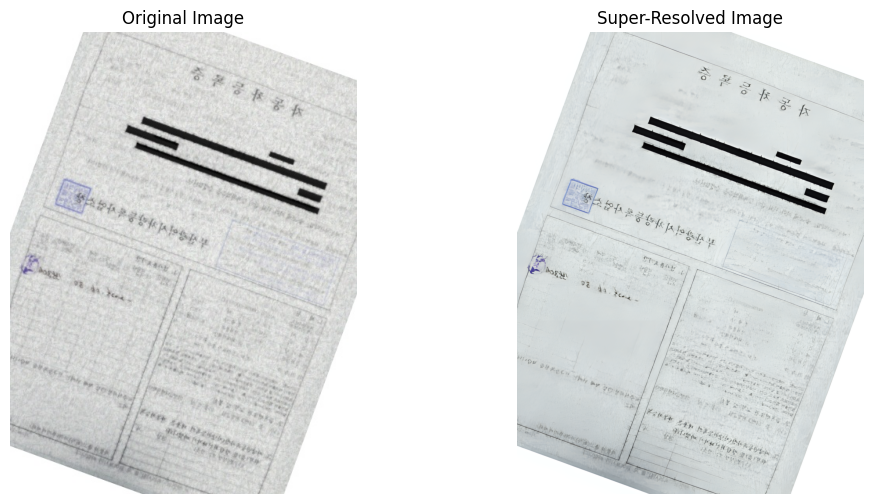

In [ ]:
model = RealESRGAN(device, scale=4)
model.load_weights('weights/RealESRGAN_x4.pth', download=True)

path_to_image = f'{test_path}/009b22decbc7220c.jpg'
image = Image.open(path_to_image).convert('RGB')

sr_image = model.predict(image)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Super-resolved image
plt.subplot(1, 2, 2)
plt.imshow(sr_image)
plt.title('Super-Resolved Image')
plt.axis('off')

plt.show()

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [29]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# model_name = 'google/vit-base-patch16-224'
# model = ViTForImageClassification.from_pretrained(
#     model_name,
#     num_labels=num_classes,
#     ignore_mismatched_sizes=True
# ).to(device)
model_name = 'efficientvit_b2.r256_in1k'
data_config = timm.data.resolve_data_config({}, model=model_name)
transform = timm.data.create_transform(**data_config, is_training=True)
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

model.safetensors:   0%|          | 0.00/97.5M [00:00<?, ?B/s]

In [26]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

In [27]:
# 평가 함수 정의
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

In [28]:
# 예측 함수 정의
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in tqdm(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)  # 가장 높은 확률을 가진 클래스를 선택

            predictions.extend(preds.cpu().numpy())  # CPU로 이동 후 리스트에 추가

    return predictions

In [30]:
best_val_accuracy = 0.0

# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, trn_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")

    # Check if this is the best validation accuracy so far
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        # Save the model with the best validation accuracy
        torch.save(model.state_dict(), f'{data_path}/best_model_efficientvit_b2.r256_in1k.pth')
        print("Model saved with best validation accuracy.")

100%|██████████| 363/363 [00:22<00:00, 15.84it/s]


Epoch 1/20
Train Loss: 0.6365, Train Acc: 0.84
Val Loss: 1.6138, Val Acc: 0.51
Model saved with best validation accuracy.


100%|██████████| 363/363 [00:22<00:00, 16.03it/s]


Epoch 2/20
Train Loss: 0.0728, Train Acc: 0.98
Val Loss: 0.6049, Val Acc: 0.82
Model saved with best validation accuracy.


100%|██████████| 363/363 [00:22<00:00, 16.12it/s]


Epoch 3/20
Train Loss: 0.0280, Train Acc: 0.99
Val Loss: 1.5594, Val Acc: 0.56


100%|██████████| 363/363 [00:22<00:00, 16.00it/s]


Epoch 4/20
Train Loss: 0.0139, Train Acc: 1.00
Val Loss: 0.9075, Val Acc: 0.75


100%|██████████| 363/363 [00:22<00:00, 16.13it/s]


Epoch 5/20
Train Loss: 0.0155, Train Acc: 1.00
Val Loss: 1.8830, Val Acc: 0.44


100%|██████████| 363/363 [00:23<00:00, 15.78it/s]


Epoch 6/20
Train Loss: 0.0085, Train Acc: 1.00
Val Loss: 2.3206, Val Acc: 0.37


100%|██████████| 363/363 [00:22<00:00, 16.13it/s]


Epoch 7/20
Train Loss: 0.0024, Train Acc: 1.00
Val Loss: 2.4940, Val Acc: 0.51


100%|██████████| 363/363 [00:22<00:00, 16.32it/s]


Epoch 8/20
Train Loss: 0.0152, Train Acc: 1.00
Val Loss: 0.0285, Val Acc: 0.99
Model saved with best validation accuracy.


100%|██████████| 363/363 [00:22<00:00, 15.89it/s]


Epoch 9/20
Train Loss: 0.0054, Train Acc: 1.00
Val Loss: 0.8651, Val Acc: 0.77


100%|██████████| 363/363 [00:22<00:00, 16.14it/s]


Epoch 10/20
Train Loss: 0.0067, Train Acc: 1.00
Val Loss: 0.1750, Val Acc: 0.95


100%|██████████| 363/363 [00:22<00:00, 15.96it/s]


Epoch 11/20
Train Loss: 0.0084, Train Acc: 1.00
Val Loss: 0.1765, Val Acc: 0.95


100%|██████████| 363/363 [00:22<00:00, 16.19it/s]


Epoch 12/20
Train Loss: 0.0039, Train Acc: 1.00
Val Loss: 0.3364, Val Acc: 0.90


100%|██████████| 363/363 [00:22<00:00, 16.21it/s]


Epoch 13/20
Train Loss: 0.0027, Train Acc: 1.00
Val Loss: 0.0339, Val Acc: 0.99


100%|██████████| 363/363 [00:22<00:00, 16.17it/s]


Epoch 14/20
Train Loss: 0.0069, Train Acc: 1.00
Val Loss: 0.3425, Val Acc: 0.90


100%|██████████| 363/363 [00:22<00:00, 16.16it/s]


Epoch 15/20
Train Loss: 0.0043, Train Acc: 1.00
Val Loss: 0.2416, Val Acc: 0.92


100%|██████████| 363/363 [00:22<00:00, 16.23it/s]


Epoch 16/20
Train Loss: 0.0044, Train Acc: 1.00
Val Loss: 0.0103, Val Acc: 1.00
Model saved with best validation accuracy.


100%|██████████| 363/363 [00:22<00:00, 16.16it/s]


Epoch 17/20
Train Loss: 0.0004, Train Acc: 1.00
Val Loss: 0.0065, Val Acc: 1.00
Model saved with best validation accuracy.


100%|██████████| 363/363 [00:22<00:00, 15.95it/s]


Epoch 18/20
Train Loss: 0.0002, Train Acc: 1.00
Val Loss: 5.1084, Val Acc: 0.13


100%|██████████| 363/363 [00:22<00:00, 15.99it/s]


Epoch 19/20
Train Loss: 0.0114, Train Acc: 1.00
Val Loss: 1.6307, Val Acc: 0.63


100%|██████████| 363/363 [00:22<00:00, 16.03it/s]

Epoch 20/20
Train Loss: 0.0050, Train Acc: 1.00
Val Loss: 0.1588, Val Acc: 0.95


# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [31]:
model.load_state_dict(torch.load(f'{data_path}/best_model_efficientvit_b2.r256_in1k.pth'))
model.eval()
preds_list = []

for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

<ipython-input-31-0821133abf01>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{data_path}/best_model_efficientvit_b2.r256_in1k.pth'))
1

In [32]:
pred_df = pd.DataFrame({
    'ID': test_df['ID'],  # Assuming 'image_name' is the column in test_df containing image IDs
    'target': preds_list
})

In [33]:
sample_submission_df = pd.read_csv(f'{data_path}/sample_submission.csv')
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [34]:
pred_df.to_csv(f'{data_path}/pred.csv', index=False)

In [35]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,13
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2
